<a href="https://colab.research.google.com/github/TayJen/H_Tatarsan2022/blob/main/H_Tatarstan2022_Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Импорт библиотек + необходимые установки

In [1]:
%cd /content/drive/MyDrive/H_Tatarstan2022/
!pwd

/content/drive/MyDrive/H_Tatarstan2022
/content/drive/MyDrive/H_Tatarstan2022


In [2]:
!pip install --quiet map-boxes
!pip install --quiet pycocotools
!pip install --quiet map-boxes

In [3]:
# !git clone https://github.com/pytorch/vision.git

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

np.random.seed(59)

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# We will be reading images using OpenCV
import cv2

In [6]:
import torch
import torchvision
from torchvision import transforms as torchtransforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import HorizontalFlip, AdvancedBlur
from albumentations.augmentations.transforms import GaussianBlur, ToGray 
from albumentations.augmentations.crops.transforms import RandomSizedCrop 

In [7]:
from torch.utils.data import Dataset

## Подготовка данных

Для модели FasterRCNN нам необходимо создать кастомный датасет

In [8]:
DATA_PATH = './data/train'

class ImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir

        self.images_dir = os.path.join(self.files_dir, 'images')
        self.labels_dir = os.path.join(self.files_dir, 'yolo_labels')

        self.height = height
        self.width = width
        
        self.imgs = [image
                     for image in sorted(os.listdir(self.images_dir))
                     if image[-4:] == '.jpg']
        
        # classes: 0 index is reserved for background
        self.classes = ['', 'human', 'head', 'face', 'car', 'carplate']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # reading the images and converting them to correct size   
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res = img_res / 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.labels_dir, annot_filename)
        
        boxes = []
        labels = []
        
        # box coordinates for xml files are extracted and corrected for image size given
        with open(annot_file_path, 'r') as annot_f:
            for ex in annot_f.readlines():
                ex = ex.split(' ')

                # Так как 0 нужен для отсутствия
                label = int(ex[0]) + 1

                # Имеющиеся данные
                x_center = float(ex[1])
                y_center = float(ex[2])
                width_obj = float(ex[3])
                height_obj = float(ex[4])

                # Необходимые для модели данные
                xmin = (x_center - width_obj / 2) * self.width
                xmax = (x_center + width_obj / 2) * self.width
                ymin = (y_center - height_obj / 2) * self.height
                ymax = (y_center + height_obj / 2) * self.height

                labels.append(label)
                boxes.append([xmin, ymin, xmax, ymax])
        
        # convert boxes and labels into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image=img_res,
                                     bboxes=target['boxes'],
                                     labels=labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = ImagesDataset(DATA_PATH, 416, 416)
print('Length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.
img, target = dataset[599]
print(img.shape, '\n', target)

Length of dataset =  2002 

(416, 416, 3) 
 {'boxes': tensor([[346.5367, 262.5807, 362.0500, 305.5520],
        [245.2450, 153.7659, 252.1848, 174.6699],
        [171.6650, 156.3467, 178.5138, 179.7197],
        [186.9920, 204.2329, 203.3958, 254.2839],
        [157.6662, 143.0578, 163.7610, 166.9855],
        [166.3783, 202.2607, 177.2377, 239.3078],
        [134.5760, 141.9022, 141.0868, 166.6080],
        [234.9100, 149.6444, 242.2073, 172.7671],
        [185.8783, 230.2444, 199.4070, 273.9861],
        [211.3800, 253.4904, 226.0050, 299.6356],
        [287.5492, 277.3988, 302.4038, 325.4969],
        [170.1440, 216.4510, 181.6728, 258.2243],
        [126.0220, 141.3244, 133.0788, 165.6566],
        [352.5167, 277.9496, 373.1217, 316.5837],
        [190.0080, 229.7129, 194.3608, 236.3804],
        [356.1372, 262.5846, 360.1282, 271.8329],
        [129.0575, 141.7790, 130.7497, 145.0068],
        [238.0430, 149.6252, 240.7643, 153.7428],
        [190.8552, 209.5022, 194.3608, 215.095

Проверим скрипт, визуализировав

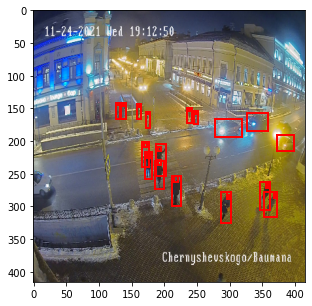

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth=2,
                                 edgecolor='r',
                                 facecolor='none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes.
img, target = dataset[599]
plot_img_bbox(img, target)

In [20]:
# Send train=True fro training transforms and False for val/test transforms
# ToTensorV2 converts image to pytorch tensor without div by 255
def get_transform(train):
    if train:
        return A.Compose([
                            # RandomSizedCrop([200, 200], width=416, height=416, p=0.5),
                            A.OneOf([
                                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                                    val_shift_limit=0.2, p=0.5),
                                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                        contrast_limit=0.2, p=0.5),
                            ], p=0.5),
                            A.OneOf([
                                AdvancedBlur(p=0.5),
                                GaussianBlur(p=0.5),
                            ], p=0.5),
                            ToGray(p=0.1), 
                            HorizontalFlip(p=0.5),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [21]:
# use our dataset and defined transformations
dataset = ImagesDataset(DATA_PATH, 416, 416, transforms=get_transform(train=True))
dataset_test = ImagesDataset(DATA_PATH, 416, 416, transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(59)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset) * test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

In [23]:
# for img, target in dataset:
#     if target['boxes'].shape == torch.Size([0]):
#         print(dataset.dataset.imgs[target['image_id']])
#         print(target)
#         break

In [24]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=16, shuffle=False,
    collate_fn=utils.collate_fn)

## Модель

In [25]:
!nvidia-smi

Sat Aug 13 12:55:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    27W /  70W |    820MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def get_object_detection_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = fasterrcnn_resnet50_fpn(pretrained=True,
                                    trainable_backbone_layers=2)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [27]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [28]:
num_classes = 6

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from engine import train_one_epoch, evaluate

# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/101]  eta: 0:08:30  lr: 0.000055  loss: 5.2200 (5.2200)  loss_classifier: 1.8475 (1.8475)  loss_box_reg: 0.7403 (0.7403)  loss_objectness: 2.1383 (2.1383)  loss_rpn_box_reg: 0.4940 (0.4940)  time: 5.0545  data: 1.1981  max mem: 9700
Epoch: [0]  [ 10/101]  eta: 0:13:01  lr: 0.000554  loss: 3.4628 (3.4453)  loss_classifier: 1.5779 (1.4306)  loss_box_reg: 0.6555 (0.6414)  loss_objectness: 0.7852 (0.9474)  loss_rpn_box_reg: 0.4101 (0.4259)  time: 8.5905  data: 6.1420  max mem: 9953
Epoch: [0]  [ 20/101]  eta: 0:11:37  lr: 0.001054  loss: 2.1908 (2.6880)  loss_classifier: 0.6778 (1.0167)  loss_box_reg: 0.5527 (0.5834)  loss_objectness: 0.3908 (0.6872)  loss_rpn_box_reg: 0.3918 (0.4008)  time: 8.7951  data: 6.4763  max mem: 9953
Epoch: [0]  [ 30/101]  eta: 0:10:12  lr: 0.001553  loss: 1.6974 (2.3193)  loss_classifier: 0.4712 (0.8170)  loss_box_reg: 0.5029 (0.5676)  loss_objectness: 0.2978 (0.5467)  loss_rpn_box_reg: 0.3549 (0.3880)  time: 8.6505  data: 6.3054  max mem: 9954


## Предсказания и проверка модели

In [ ]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.5):
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtransforms.ToPILImage()(img.cpu()).convert('RGB')

In [ ]:
# pick one image from the test set
img, target = dataset_test[59]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
prediction = {key: prediction[key].cpu() for key in prediction}

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.25)
print('nms prediciton #boxes: ', len(nms_prediction['labels']))

In [ ]:
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
print(nms_prediction)

In [ ]:
# У сабсета мы можем обратится к главному датасету и получить имя картинки,
# Для корректного сохранения результатов в pd.DataFrame
dataset_test.dataset.imgs[target['image_id']]

In [ ]:
def get_predictions(dataset_subset):
    solution = []
    scale = dataset_subset.dataset.width

    model.eval()
    with torch.no_grad():
        for img, target in tqdm(dataset_subset):
            prediction = model([img.to(device)])[0]
            nms_prediction = apply_nms(prediction, iou_thresh=0.15)
            prediction = {key: nms_prediction[key].cpu() for key in nms_prediction}

            for pred_num in range(len(prediction['labels'])):
                # Для предсказания
                xmin, ymin, xmax, ymax = prediction['boxes'][pred_num] / scale
                # Обратно к режиму без background
                cls = prediction['labels'][pred_num] - 1
                conf = prediction['scores'][pred_num]
                img_name = dataset_subset.dataset.imgs[target['image_id']]

                solution.append([img_name, cls.item(), conf.item(),
                                 xmin.item(), xmax.item(), ymin.item(), ymax.item()])
    return solution


def get_labels(dataset_subset):
    labels = []
    scale = dataset_subset.dataset.width
    for _, target in tqdm(dataset_subset):
        for lbl_num in range(len(target['labels'])):
            # Для предсказания
            xmin, ymin, xmax, ymax = target['boxes'][lbl_num] / scale
            # Обратно к режиму без background
            cls = target['labels'][lbl_num] - 1
            img_name = dataset_subset.dataset.imgs[target['image_id']]

            labels.append([img_name, cls.item(),
                                xmin.item(), xmax.item(), ymin.item(), ymax.item()])
    return labels

In [ ]:
solutions = get_predictions(dataset_test)
solutions[-1]

In [ ]:
labels = get_labels(dataset_test)
labels[-1]

In [ ]:
solutions_df = pd.DataFrame(solutions, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])
solutions_df.head()

In [ ]:
test_labels_df = pd.DataFrame(labels, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])
test_labels_df.head()

In [ ]:
from map_boxes import mean_average_precision_for_boxes as map_boxes

mean_ap, average_precisions = map_boxes(test_labels_df,
                                        solutions_df,
                                        iou_threshold=0.25,
                                        verbose=False)
mean_ap

## Предсказание для сайта

In [ ]:
class ImagesDatasetTest(torch.utils.data.Dataset):

    def __init__(self, test_dir, width, height, transforms=None):
        self.transforms = transforms
        self.test_dir = test_dir

        self.height = height
        self.width = width
        
        self.imgs = [image
                     for image in sorted(os.listdir(self.test_dir))
                     if image[-4:] == '.jpg']
        
        # classes: 0 index is reserved for background
        self.classes = ['', 'human', 'head', 'face', 'car', 'carplate']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.test_dir, img_name)

        # reading the images and converting them to correct size   
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res = img_res / 255.0

        if self.transforms:
            sample = self.transforms(image=img_res)
            img_res = sample['image']

        return img_res, img_name

    def __len__(self):
        return len(self.imgs)

In [ ]:
TEST_PATH = './data/test/images'

dataset_test_site = ImagesDatasetTest(TEST_PATH, 416, 416, transforms=ToTensorV2(p=1.0))
print('Length of dataset = ', len(dataset_test_site), '\n')

In [ ]:
dataset_test_site[0][1]

In [ ]:
def get_predictions_site(dataset):
    solution = []
    scale = dataset.width

    model.eval()
    with torch.no_grad():
        for img, img_name in tqdm(dataset):
            prediction = model([img.to(device)])[0]
            nms_prediction = apply_nms(prediction, iou_thresh=0.25)
            prediction = {key: nms_prediction[key].cpu() for key in nms_prediction}

            for pred_num in range(len(prediction['labels'])):
                # Для предсказания
                xmin, ymin, xmax, ymax = prediction['boxes'][pred_num] / scale
                # Обратно к режиму без background
                cls = prediction['labels'][pred_num] - 1
                conf = prediction['scores'][pred_num]

                solution.append([img_name, cls.item(), conf.item(),
                                 xmin.item(), xmax.item(), ymin.item(), ymax.item()])
    return solution

In [ ]:
solutions_site = get_predictions_site(dataset_test_site)

In [ ]:
solutions_site_df = pd.DataFrame(solutions_site, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])
solutions_site_df.head()

In [ ]:
solutions_site_df.sort_values(['ImageID', 'LabelName', 'Conf'],
                              ascending=[True, True, False],
                              inplace=True)
solutions_site_df.head()

In [ ]:
solutions_site_df = solutions_site_df[solutions_site_df.Conf >= 0.25].reset_index(drop=True)
solutions_site_df.head()

In [ ]:
solutions_site_df.describe()

In [ ]:
solutions_site_df.to_csv("solutions/faster_rcnn_lr_scheduler_more_aug.csv",
                         sep=';', index=False)

### Проверка предсказания

In [ ]:
path = "solutions/faster_rcnn_lr_scheduler_more_aug.csv"

df = pd.read_csv(path, sep=';')
df.head()